# Train Test Split plotting for SVM

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
df = pd.read_csv('../../Data/OASIS/oasis_3.csv')
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df.loc[df['Diagnosis'] == 'control', 'Diagnosis'] = -1
df.loc[df['Diagnosis'] == 'dementia', 'Diagnosis'] = 1
df = df.drop(['MR ID', 'Freesurfer ID', 'M/F', 'cdr', 'apoe'], axis=1) # Drop categorical and redundant columns

In [3]:
df.head()

,Diagnosis,Age,mmse,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,
OAS30001,-1,73.0,30.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,-1,73.0,29.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,-1,66.0,29.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,-1,61.0,30.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,-1,54.0,30.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

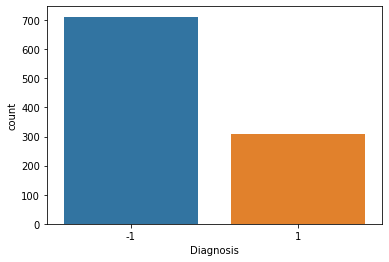

In [4]:
sns.countplot(df['Diagnosis'])

In [5]:
# standard z score scaling
def scale(X):
    u = np.mean(X)
    s = np.std(X)
    X_scaled = (X-u)/s
    return X_scaled

### Splitting the Data

In [6]:
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']
y = y.astype('int')
print(X.shape, y.shape)

(1022, 15) (1022,)


In [7]:
# X_test and y_test will not be touched until after the cross validation process is finished
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Scale the data
X_val = scale(X_val)
X_test = scale(X_test)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(511, 15) (511, 15) (511,) (511,)


## SVM Model

In [8]:
class SVM:
    # Larger lambda gives a wider margin and smaller lambda results in the narrow margin
    # for infinitely small λ the SVM becomes hard margin
    def __init__(self, learning_rate=0.001, lambd=0.01, iterations=1000, verbose=True):
        self.lambd = lambd
        self.learning = learning_rate
        self.iterations = iterations
        self.w = None
        self.b = None
        self.losses = []
        self.verbose=verbose

    def fit(self, X, y):
        
        self.w = np.random.normal(size=X.shape[1])
        self.b = np.random.normal()
        
        y_np = np.array(y)

        for i in (tqdm(range(self.iterations)) if self.verbose else range(self.iterations)):
            tot_loss = 0
            for idx, xi in enumerate(X):
                #print(idx, xi)
                loss = max(0, 1-(y_np[idx] * (np.dot(self.w, xi) - self.b)))
                tot_loss += loss
                if y_np[idx] * (np.dot(self.w, xi) - self.b) >= 1:
                    dw = 2 * self.lambd * self.w
                    #dw = 2 * 1/(i+1) * self.w
                    db = 0
                    self.w -= self.learning * dw
                    self.b -= self.learning * db
                else:
                    dw = 2 * self.lambd * self.w - np.dot(y_np[idx], xi)
                    #dw = 2 * 1/(i+1) * self.w - np.dot(y_np[idx], xi)
                    db = y_np[idx]
                    self.w -= self.learning * dw
                    self.b -= self.learning * db
            self.losses.append(tot_loss)

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [9]:
model = SVM()
model.fit(np.array(X_val), y_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
predictions = model.predict(X_test)

### ROC Curve

SVM AUC: 0.7986301369863014
No classificer AUC: 0.5


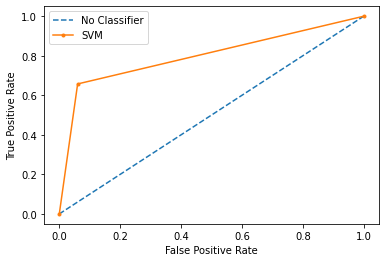

In [11]:
from sklearn.metrics import roc_curve, auc

no_classification = [0 for _ in range(len(y_test))]
nc_fpr, nc_tpr, nc_thresholds = roc_curve(y_test, no_classification)

svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, predictions)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(nc_fpr, nc_tpr, linestyle='--', label='No Classifier')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

svm_auc = auc(svm_fpr, svm_tpr)
nc_auc = auc(nc_fpr, nc_tpr)
print(f'SVM AUC: {svm_auc}\nNo classificer AUC: {nc_auc}')

### Results Analysis

In [12]:
correct_preds = np.sum(predictions == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')

Accuracy: 0.8590998043052838


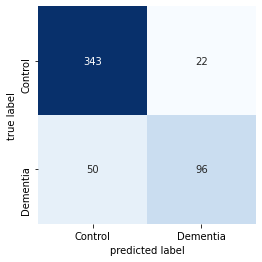

In [13]:
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, predictions)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');

In [14]:
for i in range(X_test.columns.shape[0]):
    if(model.w[i] < 0):
        print("%-27s %-3s %f" % (X_test.columns[i], ':', model.w[i]))
    else:
        print("%-27s %-3s  %f" % (X_test.columns[i], ':',  model.w[i]))
print(f'Bias value of model: {model.b}')

Age                         :   -0.203860
mmse                        :   -1.420023
TotalHippocampusVol         :   -0.518157
IntraCranialVol             :    0.351632
lhCortexVol                 :   -0.022885
rhCortexVol                 :   -0.032119
CortexVol                   :   -0.027643
SubCortGrayVol              :    0.058964
TotalGrayVol                :    0.021923
SupraTentorialVol           :    0.079922
lhCorticalWhiteMatterVol    :    0.062766
rhCorticalWhiteMatterVol    :   -0.235318
CorticalWhiteMatterVol      :   -0.087335
L.SurfArea                  :   -0.053132
R.SurfArea                  :    0.000184
Bias value of model: 0.5484302533077576


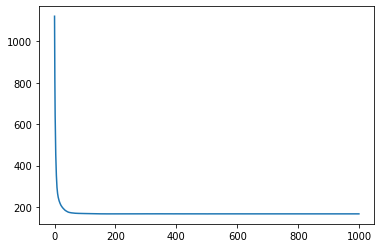

In [15]:
plt.plot(model.losses)

## Plotting with varying training test sizes and comparing

In [16]:
from sklearn import svm

In [17]:
my_results = []  # will store the results, in the format of (accuracy, training_size, marker)
sk_results = []
for i in tqdm(range(50, 460, 20)):
    for _ in range(5):
        X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_val, y_val, train_size=(i/X_val.shape[0]))
        #print('>>>', X_train_val.shape, X_test_val.shape, y_train_val.shape, y_test_val.shape)

        my_model = SVM(verbose=False)
        my_model.fit(np.array(X_train_val), y_train_val)
        
        my_predictions = my_model.predict(X_train_val)
        my_correct_preds = np.sum(my_predictions == y_train_val)
        my_accuracy = my_correct_preds/y_train_val.size
        my_results.append((my_accuracy, X_train_val.shape[0], '+'))
        #print(my_accuracy)
        
        my_predictions = my_model.predict(X_test_val)
        my_correct_preds = np.sum(my_predictions == y_test_val)
        my_accuracy = my_correct_preds/y_test_val.size
        my_results.append((my_accuracy, X_train_val.shape[0], 'x'))
        #print(my_accuracy)
        
        my_predictions = my_model.predict(X_test)
        my_correct_preds = np.sum(my_predictions == y_test)
        my_accuracy = my_correct_preds/y_test.size
        my_results.append((my_accuracy, X_train_val.shape[0], 'o'))
        #print(my_accuracy)
        
        sk_model = svm.SVC()
        sk_model.fit(X_train_val, y_train_val)
        
        sk_predictions = sk_model.predict(X_train_val)
        sk_correct_preds = np.sum(sk_predictions == y_train_val)
        sk_accuracy = sk_correct_preds/y_train_val.size
        sk_results.append((sk_accuracy, X_train_val.shape[0], '+'))
        #print(sk_accuracy)
        
        sk_predictions = sk_model.predict(X_test_val)
        sk_correct_preds = np.sum(sk_predictions == y_test_val)
        sk_accuracy = sk_correct_preds/y_test_val.size
        sk_results.append((sk_accuracy, X_train_val.shape[0], 'x'))
        #print(sk_accuracy)
        
        sk_predictions = sk_model.predict(X_test)
        sk_correct_preds = np.sum(sk_predictions == y_test)
        sk_accuracy = sk_correct_preds/y_test.size
        sk_results.append((sk_accuracy, X_train_val.shape[0], 'o'))
        #print(sk_accuracy)

  0%|          | 0/21 [00:00<?, ?it/s]

(315, 3) + (315, 3) = 630


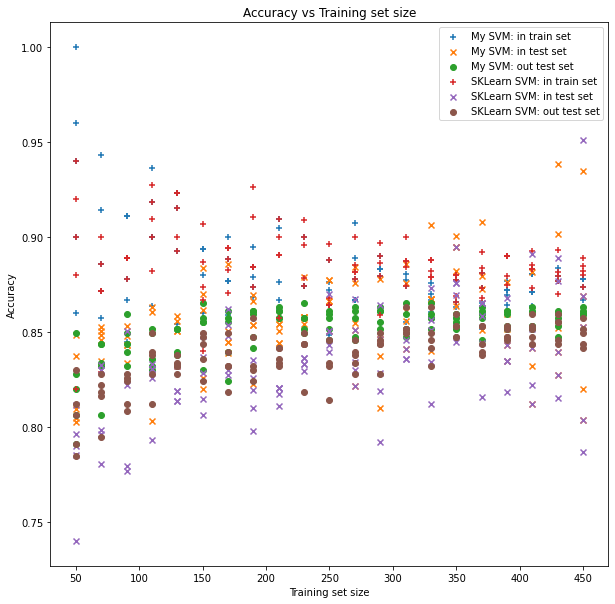

In [18]:
my_results = np.array(my_results)
sk_results = np.array(sk_results)
print(f'{my_results.shape} + {sk_results.shape} = {my_results.shape[0] + sk_results.shape[0]}')
fig, ax = plt.subplots(figsize=(10,10),facecolor='white')
x = my_results[:,1]
x = x.astype('float')
y = my_results[:,0]
y = y.astype('float')
markers = my_results[:,2]
labels = ['My SVM: in train set', 'My SVM: in test set', 'My SVM: out test set', 'SKLearn SVM: in train set', 'SKLearn SVM: in test set', 'SKLearn SVM: out test set']

ax.scatter(x[markers=='+'],y[markers=='+'], marker='+', label=labels[0])
ax.scatter(x[markers=='x'],y[markers=='x'], marker='x', label=labels[1])
ax.scatter(x[markers=='o'],y[markers=='o'], marker='o', label=labels[2])

x = sk_results[:,1]
x = x.astype('float')
y = sk_results[:,0]
y = y.astype('float')
ax.scatter(x[markers=='+'],y[markers=='+'], marker='+', label=labels[3])
ax.scatter(x[markers=='x'],y[markers=='x'], marker='x', label=labels[4])
ax.scatter(x[markers=='o'],y[markers=='o'], marker='o', label=labels[5])
    
ax.set_title("Accuracy vs Training set size")
ax.set_xlabel("Training set size")
ax.set_ylabel("Accuracy")
ax.legend(labels)
plt.savefig('accuracy_vs_train_test_total.png')

In [19]:
from collections import defaultdict

d = defaultdict(list)
for accuracy, test_size, marker in my_results:
    d[(int(test_size),marker)].append(float(accuracy))
my = [(sum(v) / len(v), k[0], k[1]) for k, v in d.items()]

d = defaultdict(list)
for accuracy, test_size, marker in sk_results:
    d[(int(test_size),marker)].append(float(accuracy))

sk = [(sum(v) / len(v), k[0], k[1]) for k, v in d.items()]

(63, 3) + (63, 3) = 126


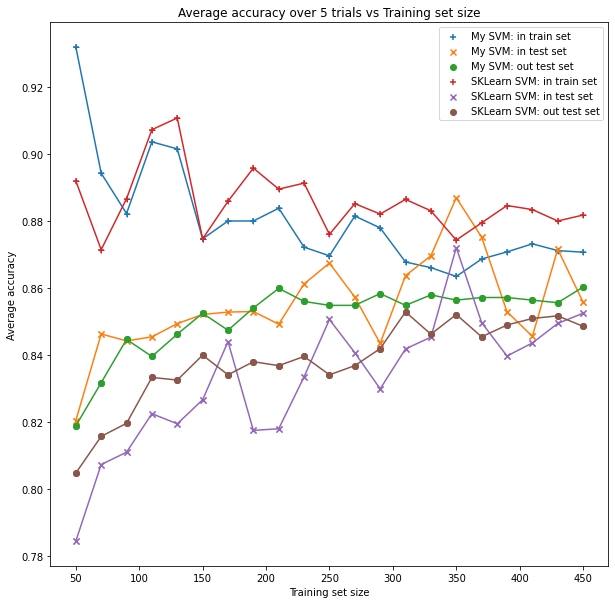

In [20]:
my = np.array(my)
sk = np.array(sk)
print(f'{my.shape} + {sk.shape} = {my.shape[0] + sk.shape[0]}')
fig, ax = plt.subplots(figsize=(10,10),facecolor='white')
x = my[:,1]
x = x.astype('float')
y = my[:,0]
y = y.astype('float')
markers = my[:,2]
labels = ['My SVM: in train set', 'My SVM: in test set', 'My SVM: out test set', 'SKLearn SVM: in train set', 'SKLearn SVM: in test set', 'SKLearn SVM: out test set']
ax.scatter(x[markers=='+'],y[markers=='+'], marker='+', label=labels[0])
ax.plot(x[markers=='+'],y[markers=='+'], marker='+')
ax.scatter(x[markers=='x'],y[markers=='x'], marker='x', label=labels[1])
ax.plot(x[markers=='x'],y[markers=='x'], marker='x')
ax.scatter(x[markers=='o'],y[markers=='o'], marker='o', label=labels[2])
ax.plot(x[markers=='o'],y[markers=='o'], marker='o')
    

x = sk[:,1]
x = x.astype('float')
y = sk[:,0]
y = y.astype('float')
markers = sk[:,2]
ax.scatter(x[markers=='+'],y[markers=='+'], marker='+', label=labels[3])
ax.plot(x[markers=='+'],y[markers=='+'], marker='+')
ax.scatter(x[markers=='x'],y[markers=='x'], marker='x', label=labels[4])
ax.plot(x[markers=='x'],y[markers=='x'], marker='x')
ax.scatter(x[markers=='o'],y[markers=='o'], marker='o', label=labels[5])
ax.plot(x[markers=='o'],y[markers=='o'], marker='o')

ax.set_title("Average accuracy over 5 trials vs Training set size")
ax.set_xlabel("Training set size")
ax.set_ylabel("Average accuracy")
ax.legend()
plt.savefig('accuracy_vs_train_test_average.png')

## Visualization

In [21]:
def visualize_svm(ax, X_test, y_test, predictions, clf, feature_1, feature_2):
    X = np.array(X_test)
    def get_hyperplane_value(x, w, b, offset):
        return (-w[feature_1] * x + b + offset) / w[feature_2]

    # control prediction, control true
    idx = np.where((y_test==-1) & (predictions==-1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="+", c='C0', label="Pred:C, True:C")
    # control prediction, dementia true
    idx = np.where((y_test==1) & (predictions==-1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="+", c='C1', label="Pred:C, True:D")
    # dementia prediction, dementia true
    idx = np.where((y_test==1) & (predictions==1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="x", c='C1', label="Pred:D, True:D")
    # dementia prediction, control true
    idx = np.where((y_test==-1) & (predictions==1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="x", c='C0', label="Pred:D, True:C")

    x0_1 = np.amin(X[:, feature_1])
    x0_2 = np.amax(X[:, feature_1])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, feature_2])
    x1_max = np.amax(X[:, feature_2])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    ax.set_xlabel(X_test.columns[feature_1])
    ax.set_ylabel(X_test.columns[feature_2])
    ax.set_title(f'{X_test.columns[feature_2]} vs {X_test.columns[feature_1]}')
    ax.legend()

    return ax


# for feature_1 in range(X_test.shape[1]):
#     fig, axes = plt.subplots(7, 2, figsize=(16,40))
#     axes = axes.flatten()
#     i = 0
#     for feature_2 in range(X_test.shape[1]):
#         if feature_1 == feature_2:
#             continue
#         axes[i] = visualize_svm(axes[i], X_test, y_test, predictions, model, feature_1, feature_2)
#         i+=1